In [3]:
import sys
import os
import math

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets

from IPython.display import display, HTML

# Finally, BGlib itself
sys.path.append('..')

from BGlib import be as belib
import pyUSID as usid
import sidpy

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
max_mem         = 1024*8
max_cores       = None  

In [ ]:
# pycroscopy에서 제공하는 bfo_iv_final.hf5로 시도하려했으나 실패
input_file_path = r'C:\Test_pycroscopy\pycroscopy\sample_data\bfo_iv_final.hf5'

(data_dir, filename) = os.path.split(input_file_path)

if input_file_path.endswith('.hf5'):
    # No translation here
    h5_path = input_file_path
    force = False # Set this to true to force patching of the datafile.
    tl = belib.translators.LabViewH5Patcher()
    tl.translate(h5_path, force_patch=force)
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        translator = belib.translators.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        translator = belib.translators.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)

h5_file = h5py.File(h5_path, 'r+')
print('Working on:\n' + h5_path)

File is already Pycroscopy ready.
Working on:
C:\Test_pycroscopy\pycroscopy\sample_data\bfo_iv_final.hf5


c:\Users\pmsda\anaconda3\envs\pycro\lib\site-packages\sidpy\sid\translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '


In [4]:
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ IV_BFO
      ------
      ├ $\sqrt E$
      ├ IV_BFO
      ├ x
      ├ y


In [5]:
h5_main = usid.hdf_utils.find_dataset(h5_file,'IV_BFO')[0]
h5_main

<HDF5 dataset "IV_BFO": shape (50, 50, 53), type "<f8">

In [45]:
h5_main.name

'/Measurement_000/Channel_000/IV_BFO/IV_BFO'

In [16]:
dict(h5_main.attrs)

{'DIMENSION_LABELS': array(['x', 'y', '$\\sqrt E$'], dtype=object),
 'DIMENSION_LIST': array([array([<HDF5 object reference>], dtype=object),
        array([<HDF5 object reference>], dtype=object),
        array([<HDF5 object reference>], dtype=object)], dtype=object),
 'data_type': 'SPECTRAL_IMAGE',
 'machine_id': 'LAP129928.ornl.gov',
 'main_data_name': 'generic',
 'modality': 'generic',
 'platform': 'Windows-10-10.0.19044-SP0',
 'pyNSID_version': '0.0.3',
 'quantity': 'log J',
 'sidpy_version': '0.0.9',
 'source': 'generic',
 'timestamp': '2022_07_01-15_37_39',
 'units': '$A/m^2$'}

In [19]:
h5_main.attrs['DIMENSION_LABELS']

array(['x', 'y', '$\\sqrt E$'], dtype=object)

In [43]:
param_dict = h5_file['/Measurement_000/Channel_000/IV_BFO'].attrs
param_dict

<Attributes of HDF5 object at 1286918175696>

In [44]:
dict(param_dict)

{'machine_id': 'LAP129928.ornl.gov',
 'platform': 'Windows-10-10.0.19044-SP0',
 'pyNSID_version': '0.0.3',
 'sidpy_version': '0.0.9',
 'timestamp': '2022_07_01-15_37_39'}

In [ ]:
# Q. 이 코드가 실행되기 위해서는 h5나 hf5의 구조가 BGlib에서 설정한 그대로여야하는데 그게 원래 AFM,PFM 등을 보고 나온 결과의 양식인건지
# 구조를 보면 h5_pos_inds등으로 저장되어 있음.
fig = belib.viz.be_viz_utils.jupyter_visualize_be_spectrograms(h5_main)

AttributeError: 'Dataset' object has no attribute 'h5_pos_inds'

In [ ]:
import h5py
import numpy as np
import pyUSID

# html문서에 존재하는 h5_main을 데이터 차원이 같은 custom data만들기
# Measurement000/Channel_000/Raw_data

f_name = 'custom_h5.h5'
hf = h5py.File(f_name,'a')

''' 
<HDF5 dataset "Raw_Data": shape (100, 54560), type "<c8">
located at:
        /Measurement_000/Channel_000/Raw_Data
Data contains:
        quantity (a.u.)
Data dimensions and original shape:
Position Dimensions:
        X - size: 10
        Y - size: 10
Spectroscopic Dimensions:
        Frequency - size: 124
        Field - size: 2
        write_bias - size: 20
        read_bias - size: 11
Data Type:
        complex64
'''

measurement_group = hf.create_group('measurement_000')
channel_group = measurement_group.create_group('Channel_000')
data = channel_group.create_dataset("Raw_data",shape = (100,54560),dtype = np.complex64)
data[:] = np.random.random((100,54560)) + np.random.random((100,54560))*1j
data.attrs["located at"] = "/Measurement_000/Channel_000/Raw_Data"
data.attrs["Data contains"] = "quantity (a.u.)"
data.attrs["Data Type"] = "complex64"

In [ ]:
# sidpy로 생성하였으나 BGlib에서 원하는 파일 형식은 다름을 확인. 밑에서 pyUSID를 활용하여 데이터 생성성
import json

data.attrs["Position Dimensions"] = json.dumps({"X": 10, "Y": 10}) 
data.attrs["Spectroscopic Dimensions"] = json.dumps({"Frequency": 124,"Field": 2,"write_bias": 20,"read_bias": 11})

In [1]:
import h5py
import numpy as np
import pyUSID
from pyUSID.io.hdf_utils import write_main_dataset
from pyUSID.io.anc_build_utils import build_ind_val_matrices
from pyUSID.io import Dimension

file_name = "pyusid.h5"

with h5py.File(file_name, "a") as hf:
    measurement_group = hf.create_group("/Measurement_000")
    channel_group = measurement_group.create_group("Channel_000")


    pos_dims = [Dimension("X", "nm", np.linspace(0, 9, 10)),
                Dimension("Y", "nm", np.linspace(0, 9, 10))]

    # 의도적으로 반대로 작성
    spec_dims = [
                Dimension("Frequency", "Hz", np.linspace(0, 1, 124)),
                Dimension("Field", "V/m", np.linspace(0, 1, 2)),
                Dimension("write_bias", "V", np.linspace(0, 1, 20)),
                Dimension("read_bias", "V", np.linspace(0, 1, 11))
                 ]

    main_data = np.random.random((np.prod([len(dim.values) for dim in pos_dims]), 
                                  np.prod([len(dim.values) for dim in spec_dims]))) + 1j * np.random.random((np.prod([len(dim.values) for dim in pos_dims]), 
                                        np.prod([len(dim.values) for dim in spec_dims])))

    h5_main = write_main_dataset(
        h5_parent_group=channel_group,
        main_data=main_data,
        main_data_name="Raw_Data",
        quantity="quantity",
        pos_dims=pos_dims,  
        spec_dims=spec_dims,  
        dtype=np.complex64,
        units = 'a.u.'
    )


c:\Users\pmsda\anaconda3\envs\pycro\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1072: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')
c:\Users\pmsda\anaconda3\envs\pycro\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1129: UserWarning: pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer createsregion references for each dimension. Please use pyUSID.io.reg_ref.write_region_references to manually create region references
  warn('pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer creates'


위는 파일 생성 / 아래는 읽어오기만 해도 실행가능

In [5]:
import h5py
import pyUSID

hf = h5py.File('pyusid.h5','r+')
h5_main = pyUSID.hdf_utils.find_dataset(hf, 'Raw_Data')[0]
print(h5_main)

# html문서에서 나온 출력과 동일함을 확인 x,y와 frequency,field,write_bias,read_bias 순서가 반대인 이유를 모르겠다.
# 역순으로 저장하면 아래 analysis가 작동하지않는다.

<HDF5 dataset "Raw_Data": shape (100, 54560), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	quantity (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 10 
	Y - size: 10 
Spectroscopic Dimensions: 
	Frequency - size: 124 
	Field - size: 2 
	write_bias - size: 20 
	read_bias - size: 11
Data Type:
	complex64


In [6]:
from pyUSID.io.usi_data import check_if_main
# pyUSID 형식을 만족
check_if_main(h5_main,verbose=True)

True

In [5]:
h5_main.shape

(100, 54560)

In [7]:
from BGlib import be as belib

sho_fitter = belib.analysis.BESHOfitter(h5_main, cores=None, verbose=False, h5_target_group=hf)
sho_fitter.set_up_guess(guess_func=belib.analysis.be_sho_fitter.SHOGuessFunc.complex_gaussian,
                        num_points=5)
h5_sho_guess = sho_fitter.do_guess(override=False)
sho_fitter.set_up_fit()
h5_sho_fit = sho_fitter.do_fit(override=False)
h5_sho_grp = h5_sho_fit.parent

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
	If you are operating on a cluster and your job gets killed, re-run the job to resume



IndexError: index 23 is out of bounds for axis 0 with size 1

In [ ]:
fig = belib.viz.be_viz_utils.jupyter_visualize_be_spectrograms(h5_main)

In [9]:
# pip install .e를 통해 개발모드로 전환 후 jupyter_visualize_be_spectograms 수정
import BGlib
print(BGlib.__file__)

c:\test_pycroscopy\bglib\BGlib\__init__.py


In [ ]:
# 함수 자체에 오류 있음. html문서에서도 아래와 같이 출력되는데 사용하지 않는 함수인지 모르겠다. 문제로는 freqs_nd를 읽지못함 size오류류
from pyUSID.io.hdf_utils import reshape_to_n_dims

pc_main = h5_main
h5_pos_inds = pc_main.h5_pos_inds
pos_dims = pc_main.pos_dim_sizes
pos_labels = pc_main.pos_dim_labels

h5_spec_vals = pc_main.h5_spec_vals
h5_spec_inds = pc_main.h5_spec_inds
spec_dims = pc_main.spec_dim_sizes
spec_labels = pc_main.spec_dim_labels

ifreq = spec_labels.index('Frequency')
freqs_nd = reshape_to_n_dims(h5_spec_vals, h5_spec=h5_spec_inds)[0][ifreq].squeeze()
# freqs_2d = freqs_nd.reshape(freqs_nd.shape[0], -1) / 1000  # Convert to kHz

No position datasets found as attributes of /Measurement_000/Channel_000/Spectroscopic_Values


In [54]:
Nd_mat = h5_sho_fit.get_n_dim_form()
print('Nd_mat shape = ', Nd_mat.shape)

phase_offset = Nd_mat[0, 0, 1, 0, 0]['Phase [rad]']

print('Phase offset [rad] = ', phase_offset)

Nd_mat[:,:,:,:,:]['Phase [rad]'] = Nd_mat[:,:,:,:,:]['Phase [rad]'] - phase_offset

# '''
# Nd_mat.dtype.names
# ('Amplitude [V]', 'Frequency [Hz]', 'Quality Factor', 'Phase [rad]', 'R2 Criterion')

# Nd_mat shape =  (10, 10, 2, 20, 11)
# Phase offset [rad] =  -0.3490023
# 위에서 반대로 나오던 x,y / read,write,field 역순 shape
# data 입력할때부터 반대로 하면 h5_sho_fit함수가 작동하지 않음...
# '''


Nd_mat shape =  (10, 10, 11, 20, 2)
Phase offset [rad] =  0.33466607332229614


<p>그렇다고 위의 shape을 원래 shape인 (10,10,2,20,11)로 transpose시키면 아래 그래프가 정상작동하지 않음.</p>
그렇다고 transpose시키지 않고 진행하면 read_bias는 2로 설정됨(원래는 11).

In [55]:
def plot_line_family(axis, x_vec, line_family, line_names=None, label_prefix='', label_suffix='',
                     y_offset=0, show_cbar=False, **kwargs):
    """
    Plots a family of lines with a sequence of colors

    Parameters
    ----------
    axis : matplotlib.axes.Axes object
        Axis to plot the curve
    x_vec : array-like
        Values to plot against
    line_family : 2D numpy array
        family of curves arranged as [curve_index, features]
    line_names : array-like
        array of string or numbers that represent the identity of each curve in the family
    label_prefix : string / unicode
        prefix for the legend (before the index of the curve)
    label_suffix : string / unicode
        suffix for the legend (after the index of the curve)
    y_offset : (optional) number
        quantity by which the lines are offset from each other vertically (useful for spectra)
    show_cbar : (optional) bool
        Whether or not to show a colorbar (instead of a legend)

    """

    x_vec = np.array(x_vec)
    #assert x_vec.ndim == 1, 'x_vec must be a 1D array'
    if not isinstance(line_family, list):
        line_family = np.array(line_family)

    assert line_family.ndim == 2, 'line_family must be a 2D array'
    #    assert x_vec.shape[1] == line_family.shape[1], \
    #        'The size of the 2nd dimension of line_family must match with of x_vec, but line fam has shape {} whereas xvec has shape {}'.format(line_family.shape, x_vec.shape)
    num_lines = line_family.shape[0]


    if line_names is None:
        # label_prefix = 'Line '
        line_names = [str(line_ind) for line_ind in range(num_lines)]

    line_names = ['{} {} {}'.format(label_prefix, cur_name, label_suffix) for cur_name in line_names]

    print("Line family shape is {}".format(line_family.shape))

    for line_ind in range(num_lines):
        colors = plt.cm.get_cmap('jet', line_family.shape[-1])
        axis.plot(x_vec, line_family[line_ind] + line_ind * y_offset,
                  color = colors(line_ind),
                  )

    if show_cbar:
        # put back the cmap parameter:
        kwargs.update({'cmap': cmap})
        _ = cbar_for_line_plot(axis, num_lines, **kwargs)

No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
These are the labels ['read_bias', 'write_bias', 'Field']


interactive(children=(IntSlider(value=4, continuous_update=False, description='Read step', max=10), IntSlider(…

Button(description='Save figure', style=ButtonStyle())

Line family shape is (0, 2)


C:\Users\pmsda\AppData\Local\Temp\ipykernel_9896\3474822457.py:131: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax_colorbar.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none')


NameError: name 'output_file_path' is not defined

<Figure size 640x480 with 0 Axes>

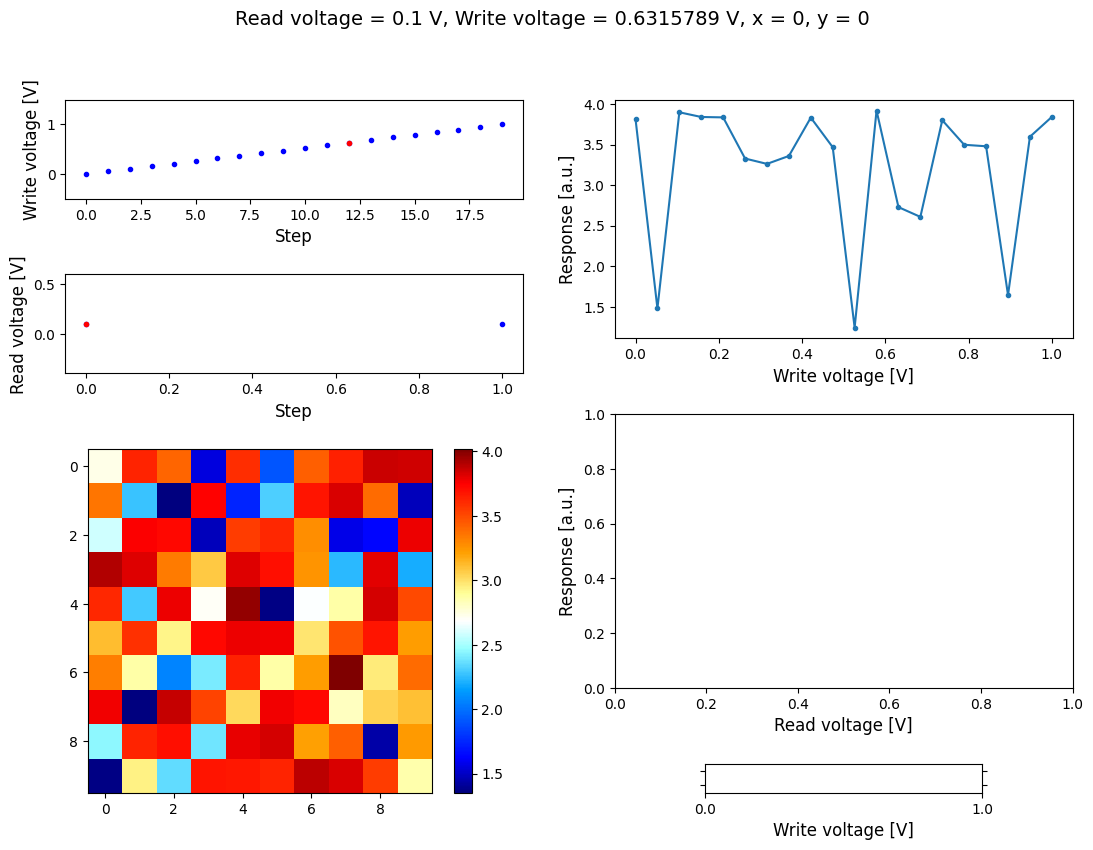

<Figure size 640x480 with 0 Axes>

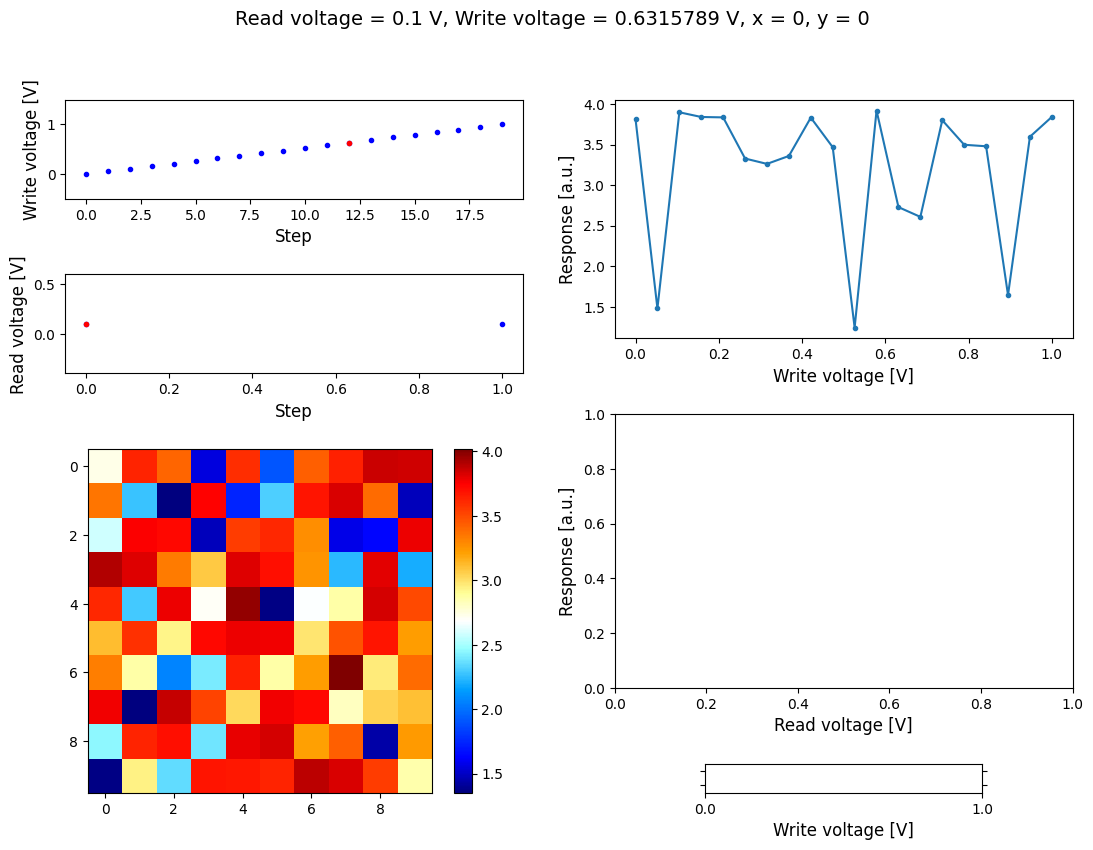

<Figure size 640x480 with 0 Axes>

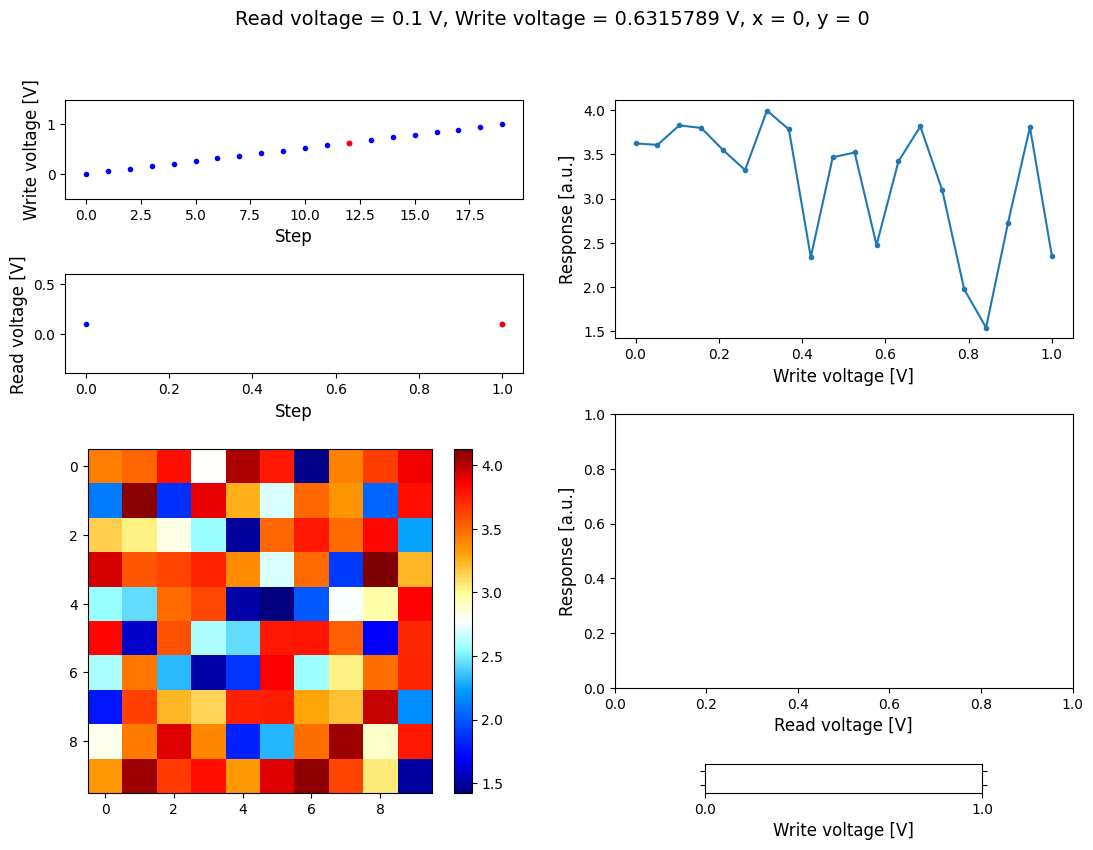

<Figure size 640x480 with 0 Axes>

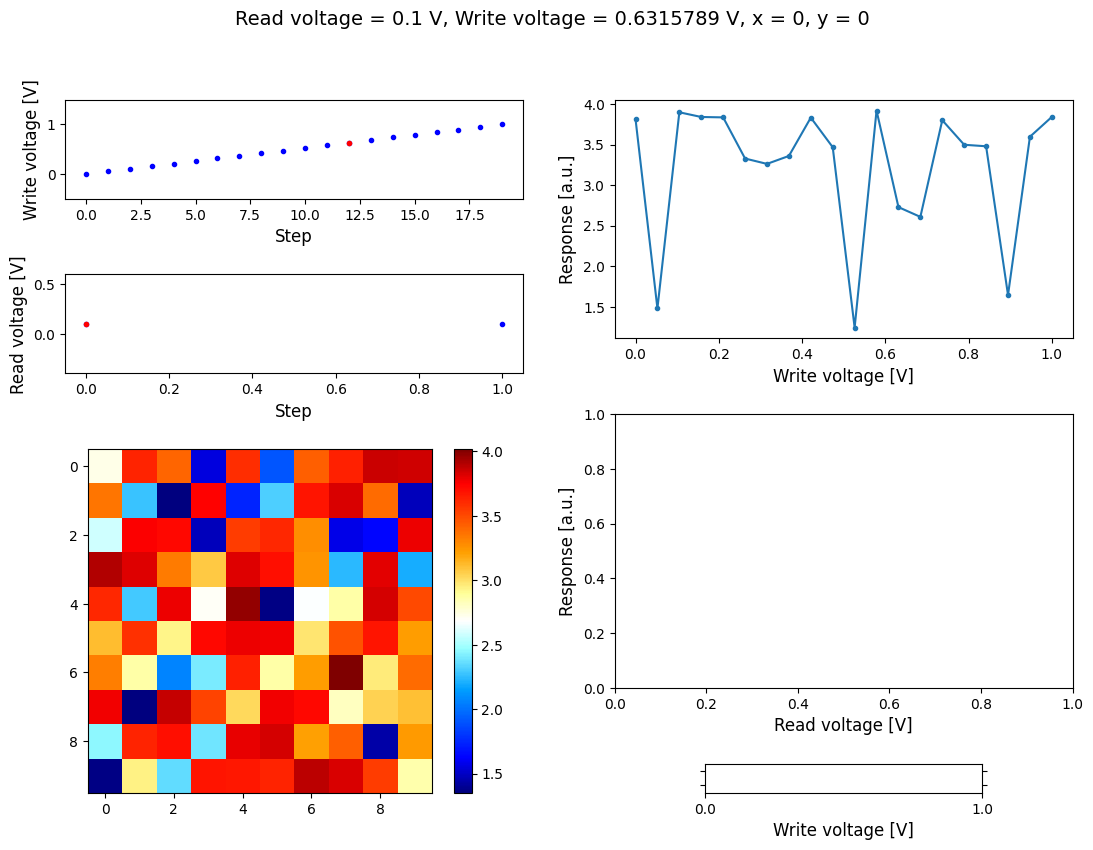

In [ ]:
import pyUSID as usid
import ipywidgets as widgets
import matplotlib.pyplot as plt
import sidpy

global option, save_figure
# Option 1: only show curves from maximum to minimum write voltage
# Option 2: Show all curves from the whole write voltage waveform
option = 1
save_figure = False # Save the figure after being generated if True
high_voltage_amplf = 1


h5_sho_spec_inds = h5_sho_fit.h5_spec_inds
h5_sho_spec_vals = h5_sho_fit.h5_spec_vals

sho_spec_labels = h5_sho_fit.spec_dim_labels
pos_labels = h5_sho_fit.pos_dim_labels

num_fields = h5_sho_fit.spec_dim_sizes[h5_sho_fit.spec_dim_labels.index('Field')]
num_write_steps = h5_sho_fit.spec_dim_sizes[h5_sho_fit.spec_dim_labels.index('write_bias')]
num_read_steps = h5_sho_fit.spec_dim_sizes[h5_sho_fit.spec_dim_labels.index('read_bias')]

# It turns out that the read voltage index starts from 1 instead of 0
# Also the VDC indices are NOT repeating. They are just rising monotonically
write_volt_index = sho_spec_labels.index('write_bias')
read_volt_index = sho_spec_labels.index('read_bias')
h5_sho_spec_inds[read_volt_index, :] -= np.min(h5_sho_spec_inds[read_volt_index, :])
h5_sho_spec_inds[write_volt_index, :] = np.tile(np.repeat(np.arange(num_write_steps), num_fields), num_read_steps)

# Get the bias matrix:
bias_mat, _ = usid.hdf_utils.reshape_to_n_dims(h5_sho_spec_vals, h5_spec=h5_sho_spec_inds)
bias_vec_r_all = bias_mat[read_volt_index]*high_voltage_amplf
bias_vec_w_all = bias_mat[write_volt_index]*high_voltage_amplf
bias_vec_w = bias_vec_w_all.reshape(h5_sho_fit.spec_dim_sizes)[1, :, 1]
bias_vec_r = bias_vec_r_all.reshape(h5_sho_fit.spec_dim_sizes)[1, :, :]

# Option 1: only show curves from maximum to minimum write voltage:
if option == 1:
    write_step_start = np.argmax(bias_vec_w)
    write_step_end = np.argmin(bias_vec_w)

# ption 2: show all curves from the whole write voltage waveform
if option == 2:
    write_step_start = 0
    write_step_end = num_write_steps-1

bias_vec_r_display = np.transpose(bias_vec_r[write_step_start:write_step_end+1,:])

print('These are the labels', sho_spec_labels)

nd_labels = h5_sho_fit.n_dim_labels

num_read_steps = Nd_mat.shape[nd_labels.index('read_bias')]
num_write_steps = Nd_mat.shape[nd_labels.index('write_bias')]
num_row = Nd_mat.shape[nd_labels.index('Y')]
num_col = Nd_mat.shape[nd_labels.index('X')]

# Indices of initial data points to plot
row = 0
col = 0
field = 1
dc_step_read = 0
dc_step_write = 0

# Select color scale range for map here
cmin = -0.0001
cmax = 0.0001

# Get the read and write data to plot
resp_vec_w = Nd_mat[row,col,field,:,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[row,col,field,:,dc_step_read]['Phase [rad]'])*1000

resp_mat_r = Nd_mat[:,:,1,dc_step_write,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[:,:,1,dc_step_write,dc_step_read]['Phase [rad]'])*1000

resp_vec_r = np.squeeze(Nd_mat[:,:,1,write_step_start:write_step_end+1,:]['Amplitude [V]']
                          * np.cos(Nd_mat[:,:,1,write_step_start:write_step_end+1,:]['Phase [rad]'])*1000)


def make_figure(resp_mat_r, resp_vec_r, resp_vec_w, dc_step_read, dc_step_write, col, row):
    global save_figure
    plt.clf();
    fig = plt.figure(figsize=(13, 9))
    fig.set_facecolor('white')

    ax_bias_w = plt.subplot2grid((20, 2), (0, 0), colspan=1, rowspan=3)
    ax_bias_r = plt.subplot2grid((20, 2), (5, 0), colspan=1, rowspan=3)
    ax_loop_w = plt.subplot2grid((20, 2), (0, 1), colspan=1, rowspan=7)
    ax_loop_r = plt.subplot2grid((20, 2), (9, 1), colspan=1, rowspan=8)
    ax_colorbar = plt.subplot2grid((20, 2), (19, 1), colspan=1, rowspan=1)
    ax_map = plt.subplot2grid((20, 2), (10, 0), colspan=1, rowspan=11)



    ax_bias_w.set_xlabel('Step', fontsize = 12)
    ax_bias_w.set_ylabel('Write voltage [V]', fontsize = 12)
    ax_bias_r.set_xlabel('Step', fontsize = 12)
    ax_bias_r.set_ylabel('Read voltage [V]', fontsize = 12)
    ax_loop_w.set_ylabel('Response [a.u.]', fontsize = 12)
    ax_loop_w.set_xlabel('Write voltage [V]', fontsize = 12)
    ax_loop_r.set_ylabel('Response [a.u.]', fontsize = 12)
    ax_loop_r.set_xlabel('Read voltage [V]', fontsize = 12)

    # Title saying read and write voltages
    fig.suptitle('Read voltage = '+str(bias_vec_r[1,dc_step_read])+' V, Write voltage = ' +str(bias_vec_w[dc_step_write])+' V'
                ', x = '+str(col)+', y = '+str(row), fontsize = 14);

    co_b = ax_map.imshow(resp_mat_r, cmap = sidpy.plot_utils.cmap_jet_white_center(), origin='upper',
                         interpolation='none');
    cb = fig.colorbar(co_b)

    #Graph of DC write voltage
    ax_bias_w.plot(bias_vec_w,'b.');
    ax_bias_w.plot(dc_step_write,bias_vec_w[dc_step_write],'r.');
    ax_bias_w.set_ylim([np.min(bias_vec_w)-0.5, np.max(bias_vec_w)+0.5])

    #Graph of DC read voltage
    ax_bias_r.plot(np.transpose(bias_vec_r[1]),'b.');
    ax_bias_r.plot(dc_step_read,np.transpose(bias_vec_r[1,dc_step_read]),'r.');
    ax_bias_r.set_ylim([np.min(bias_vec_r)-0.5, np.max(bias_vec_r)+0.5])

    #Graph of response loop (amplitude * cos(phase)) vs write voltage at selected x, y and read step
    ax_loop_w.plot(bias_vec_w, resp_vec_w,'.-');

    #Response loops (amplitude * cos(phase)) of all write voltage steps (color coded) vs read voltage at selected x, y
    plot_line_family(ax_loop_r, bias_vec_r_display[:, :],
                                   resp_vec_r, line_names='None',
                                   label_prefix='Line', label_suffix='')

    if option == 1:
        colorbar_mat = np.column_stack((range(write_step_start,write_step_end+1),range(write_step_start,write_step_end+1)))
        ax_colorbar.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none')
        ax_colorbar.set_yticklabels('')
        ax_colorbar.tick_params(axis = 'y', left = 'off', right = 'off')
        plt.sca(ax_colorbar)
        plt.xticks([0,write_step_end-write_step_start],[bias_vec_w[write_step_start],bias_vec_w[write_step_end]])
        ax_colorbar.set_xlabel('Write voltage [V]', fontsize = 12)

    if option == 2:
        colorbar_mat = np.column_stack((range(0,num_write_steps-1),range(0,num_write_steps-1)))
        ax_colorbar.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none')
        ax_colorbar.set_yticklabels('')
        ax_colorbar.tick_params(axis = 'y', left = 'off', right = 'off')
        ax_colorbar.set_xlabel('Write voltage step', fontsize = 12)


    if save_figure == True:
        fig.savefig(output_file_path+'\cb_cKPFM_Vr'+str(dc_step_read)+'_Vw'+str(dc_step_write)+'_x='+str(col)+'_y='+str(row)+'.png', format='png')
        fig.savefig(output_file_path+'\cb_cKPFM_Vr'+str(dc_step_read)+'_Vw'+str(dc_step_write)+'_x='+str(col)+'_y='+str(row)+'.eps', format='eps')
        fig.savefig(output_file_path+'\cb_cKPFM_Vr'+str(dc_step_read)+'_Vw'+str(dc_step_write)+'_x='+str(col)+'_y='+str(row)+'.tif', format='tiff')
        save_figure = False


def update_sho_plots(dc_step_read, dc_step_write, col, row, **kwargs):
    resp_vec_w = Nd_mat[row,col,field,:,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[row,col,field,:,dc_step_read]['Phase [rad]'])*1000
    resp_vec_w = Nd_mat[row,col,field,:,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[row,col,field,:,dc_step_read]['Phase [rad]'])*1000
    resp_mat_r = Nd_mat[:,:,1,dc_step_write,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[:,:,1,dc_step_write,dc_step_read]['Phase [rad]'])*1000
    resp_vec_r = (Nd_mat[row,col,field,write_step_start:write_step_end+1,:]['Amplitude [V]']
                           * np.cos(Nd_mat[row,col,field,write_step_start:write_step_end+1,:]['Phase [rad]'])*1000)

    make_figure(resp_mat_r, resp_vec_r, resp_vec_w, dc_step_read, dc_step_write, col, row)


def on_save_button_clicked(b):
    global save_figure
    save_figure = True
    dc_step_read =  dc_step_read_slider.value
    dc_step_write = dc_step_write_slider.value
    col = x_slider.value
    row = y_slider.value

    update_sho_plots(dc_step_read,dc_step_write, col, row)


slider_dict = dict()

dc_step_read_slider = widgets.IntSlider(min = 0, max = num_read_steps-1, step = 1,value = 4,
                                        description = 'Read step',continuous_update = False);
dc_step_write_slider = widgets.IntSlider(min = 0, max = num_write_steps-1, step = 1,value = 0,
                                         description = 'Write step', continuous_update = False);
x_slider = widgets.IntSlider(min = 0, max = num_col-1,step = 1,value = 0,
                             description='x',continuous_update = False);
y_slider = widgets.IntSlider(min = 0,max = num_row-1,step = 1,value = 0,
                             description = 'y',continuous_update = False);

widgets.interact(update_sho_plots,dc_step_read=dc_step_read_slider,dc_step_write=dc_step_write_slider, col = x_slider, row = y_slider, **slider_dict);

button = widgets.Button(description = 'Save figure')
display(button)
button.on_click(on_save_button_clicked)

In [ ]:
# No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
# These are the labels ['read_bias', 'write_bias', 'Field']
# html이랑 반대. html은 ['Field',write_bias,read_bias]
